In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import src.utils as utils
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

In [14]:
full_df = utils.read_and_concat_csvs_from_dir('/Users/gilmar/gharchive/')
repo_counts = full_df.group_by("repository").len("count").sort("repository")
for repo in repo_counts.to_dicts():
    print(repo["repository"], repo["count"])
repo_df = full_df.filter(pl.col("repository").is_in(["kubernetes", "kubernetes/kubernetes"]))
daily_counts_df = utils.daily_event_count(repo_df)
daily_counts_df

"envoy" 2050
"godot" 6962
"harbor" 420
"home-assistant" 1324
"kubernetes" 37772
"prometheus" 2485
envoyproxy/envoy 143053
goharbor/harbor 16158
home-assistant/core 156857
kubernetes/kubernetes 1366119
prometheus/prometheus 61733


event_date,actor_id,object_id,object_type,daily_event_count
date,str,str,str,u32
2015-08-12,"""101141""","""pr_12608""","""pr""",1
2015-08-12,"""10199099""","""issue_100619930""","""issue""",2
2015-08-12,"""10199099""","""issue_100644251""","""issue""",1
2015-08-12,"""10199099""","""issue_100651217""","""issue""",1
2015-08-12,"""10199099""","""issue_99087702""","""issue""",3
…,…,…,…,…
2021-06-30,"""9950081""","""issue_924763091""","""issue""",1
2021-06-30,"""9950081""","""issue_928613592""","""issue""",1
2021-06-30,"""9950081""","""issue_934187388""","""issue""",1


In [19]:
daily_counts_df = pl.read_csv("data/godot.csv.gz", 
        has_header=True,
        try_parse_dates=True,
        separator=",",
        encoding="utf8",)
daily_counts_df

event_date,actor_id,object_id,daily_event_count,object_type
date,i64,str,i64,str
2015-10-27,6265307,"""issue_91920046""",1,"""issue"""
2015-10-27,9574367,"""issue_113595290""",1,"""issue"""
2015-10-27,6129594,"""issue_113638875""",1,"""issue"""
2015-10-27,15351888,"""issue_113710944""",1,"""issue"""
2015-10-27,9574367,"""issue_113168033""",1,"""issue"""
…,…,…,…,…
2025-04-25,4701338,"""issue_3019657312""",1,"""issue"""
2025-04-25,66727710,"""pr_104731""",9,"""pr"""
2025-04-25,32321,"""pr_105706""",2,"""pr"""


In [20]:
stats_df = utils.rolling_window_stats(daily_counts_df, event_type="pr").filter(pl.col("rolling_unique_actors").is_not_null())

In [21]:
stats_df = stats_df.with_columns([
    (pl.col("rolling_event_count") / pl.col("rolling_unique_actors")).alias("events_per_actor")
])
stats_df

event_date,rolling_unique_actors,rolling_event_count,events_per_actor
date,u32,i64,f64
2016-05-23,63,103,1.634921
2016-05-27,62,102,1.645161
2016-05-28,63,104,1.650794
2016-05-29,64,108,1.6875
2016-05-30,65,114,1.753846
…,…,…,…
2025-04-21,636,3420,5.377358
2025-04-22,654,3502,5.35474
2025-04-23,666,3602,5.408408


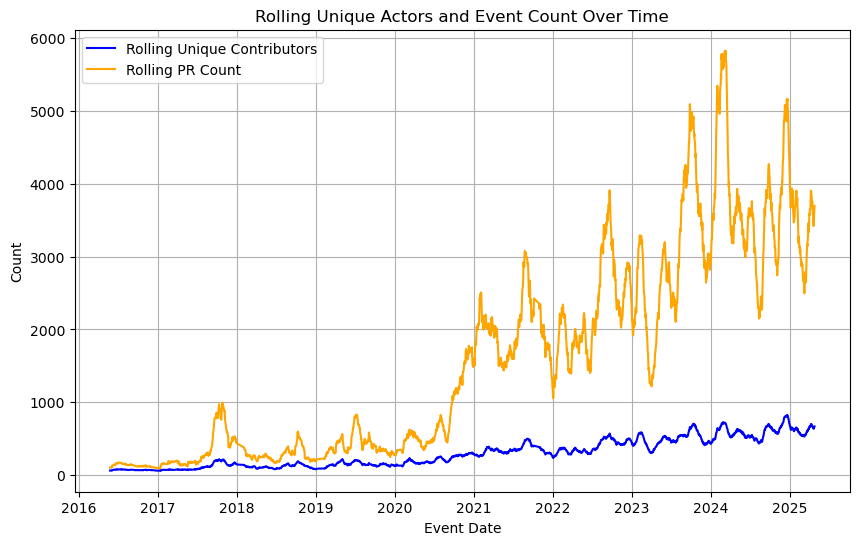

In [22]:
# Plot rolling_unique_actors and rolling_event_count as time series
plt.figure(figsize=(10, 6))
plt.plot(stats_df["event_date"], stats_df["rolling_unique_actors"], label="Rolling Unique Contributors", color="blue")
plt.plot(stats_df["event_date"], stats_df["rolling_event_count"], label="Rolling PR Count", color="orange")
plt.xlabel("Event Date")
plt.ylabel("Count")
plt.title("Rolling Unique Actors and Event Count Over Time")
plt.legend()
plt.grid(True)
plt.show()

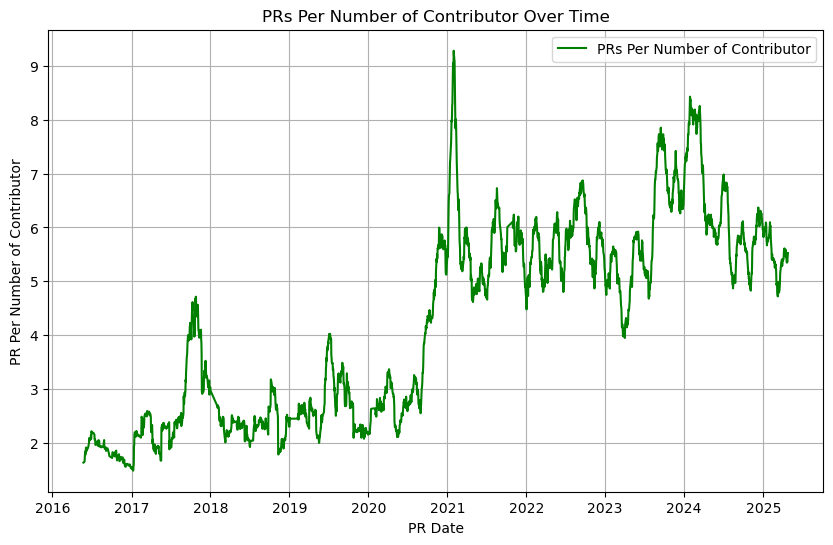

In [23]:
# Plot events_per_actor as a time series
plt.figure(figsize=(10, 6))
plt.plot(stats_df["event_date"], stats_df["events_per_actor"], label="PRs Per Number of Contributor", color="green")
plt.xlabel("PR Date")
plt.ylabel("PR Per Number of Contributor")
plt.title("PRs Per Number of Contributor Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
graph_df = utils.prepare_df_to_graph(daily_counts_df)
graphs_by_date = utils.create_graphs_by_date(graph_df)

# Process the graphs to extract metrics
metrics_df = utils.graphs_metrics_to_dataframe(graphs_by_date, smoothing_period_days=30)
metrics_df

/Users/gilmar/Library/Mobile Documents/com~apple~CloudDocs/learning/master-complex-systems/comp5313/assignments/comp5313-assignment-2/src/utils.py:269: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(


number_of_nodes,number_of_edges,average_clustering,density,average_degree,number_of_isolated_nodes,number_of_connected_components,number_of_supernodes_by_degree,number_of_supernodes_by_betweenness,average_shortest_path_length,diameter,event_date
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date
4.0,4.0,0.583333,0.666667,2.0,0.0,1.0,0.0,0.0,1.333333,2.0,2015-10-27
4.0,4.5,0.708333,0.75,2.25,0.0,1.0,0.0,0.0,1.25,2.0,2015-10-28
9.0,10.0,0.554532,0.540936,2.236842,0.0,1.0,0.333333,0.333333,1.517544,2.666667,2015-10-29
9.25,10.25,0.500899,0.466813,2.227632,0.0,1.0,0.5,0.5,1.671491,3.0,2015-10-30
8.8,9.8,0.501672,0.449641,2.239248,0.0,1.0,0.4,0.6,1.689574,3.0,2015-10-31
…,…,…,…,…,…,…,…,…,…,…,…
49.866667,58.4,0.306506,0.049524,2.317183,0.0,9.066667,2.6,2.766667,inf,inf,2025-04-21
50.4,61.3,0.317672,0.050341,2.38899,0.0,8.933333,2.666667,2.9,inf,inf,2025-04-22
50.5,61.2,0.321602,0.05011,2.380686,0.0,9.166667,2.633333,2.966667,inf,inf,2025-04-23


In [11]:
stats_and_metrics_df = stats_df.select("event_date", "events_per_actor").join(metrics_df, on="event_date", how="inner")\
    .drop(["event_date", "average_clustering", "number_of_isolated_nodes", "average_shortest_path_length", "diameter"])

# Calculate the correlation matrix
correlation_matrix = stats_and_metrics_df.corr().drop_nans().to_pandas()
correlation_matrix

,events_per_actor,number_of_nodes,number_of_edges,density,average_degree,number_of_connected_components,number_of_supernodes_by_degree,number_of_supernodes_by_betweenness
0,1.000000,0.667868,0.600297,-0.556665,-0.148969,0.416135,0.713785,0.642450
1,0.667868,1.000000,0.947619,-0.804605,-0.049112,0.805385,0.928323,0.912772
2,0.600297,0.947619,1.000000,-0.699324,0.255543,0.650268,0.870994,0.865680
3,-0.556665,-0.804605,-0.699324,1.000000,0.204264,-0.751059,-0.772738,-0.775377
4,-0.148969,-0.049112,0.255543,0.204264,1.000000,-0.387015,-0.058874,-0.026859
5,0.416135,0.805385,0.650268,-0.751059,-0.387015,1.000000,0.750574,0.777662
6,0.713785,0.928323,0.870994,-0.772738,-0.058874,0.750574,1.000000,0.956737
7,0.642450,0.912772,0.865680,-0.775377,-0.026859,0.777662,0.956737,1.000000


In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix.set_index(correlation_matrix.columns),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True
)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
# Convert event_date to datetime format
plot_metrics_df = metrics_df

# Create a figure with subplots (5 rows for 5 metrics)
fig, axes = plt.subplots(5, 1, figsize=(12, 28), sharex=False)

# Plot number_of_nodes
axes[0].plot(plot_metrics_df["event_date"], plot_metrics_df["number_of_nodes"], label="Number of Nodes", color="blue")
axes[0].set_ylabel("Number of Nodes")
axes[0].set_title("Number of Nodes Over Time")
axes[0].legend()
axes[0].grid(True)

# Plot number_of_edges
axes[1].plot(plot_metrics_df["event_date"], plot_metrics_df["number_of_edges"], label="Number of Edges", color="orange")
axes[1].set_ylabel("Number of Edges")
axes[1].set_title("Number of Edges Over Time")
axes[1].legend()
axes[1].grid(True)

# Plot average_degree
axes[2].plot(plot_metrics_df["event_date"], plot_metrics_df["average_degree"], label="Average Degree", color="green")
axes[2].set_xlabel("Event Date")
axes[2].set_ylabel("Average Degree")
axes[2].set_title("Average Degree Over Time")
axes[2].legend()
axes[2].grid(True)

# Plot number_of_connected_components
axes[3].plot(plot_metrics_df["event_date"], plot_metrics_df["number_of_connected_components"], label="Number of Connected Components", color="purple")
axes[3].set_ylabel("Connected Components")
axes[3].set_title("Number of Connected Components Over Time")
axes[3].legend()
axes[3].grid(True)

# Plot number_of_supernodes_by_degree
axes[4].plot(plot_metrics_df["event_date"], plot_metrics_df["number_of_supernodes_by_degree"], label="Supernodes by Degree", color="red")
axes[4].set_ylabel("Supernodes by Degree")
axes[4].set_title("Number of Supernodes by Degree Over Time")
axes[4].legend()
axes[4].grid(True)

# Format x-axis for better readability
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

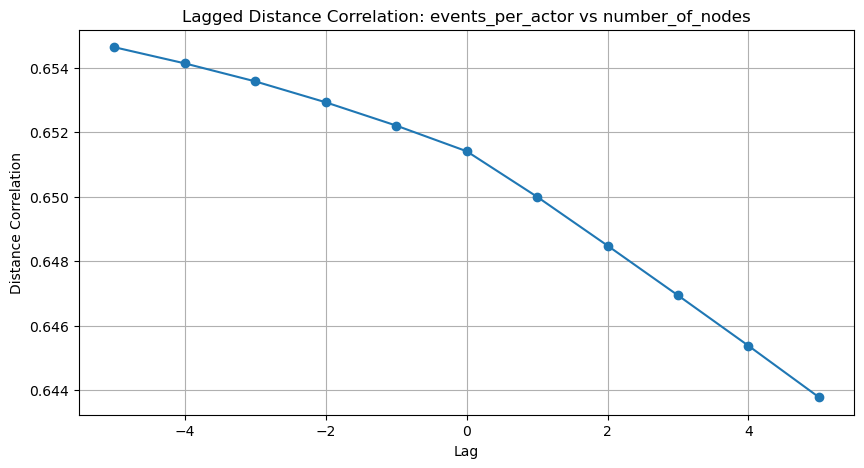

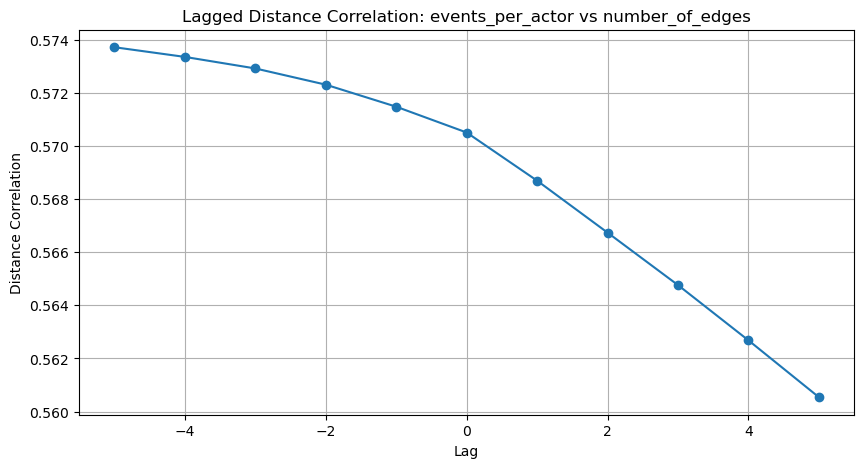

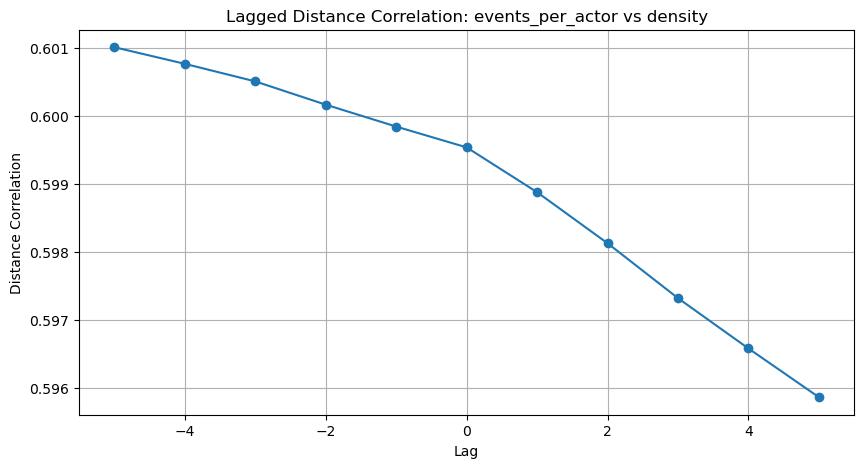

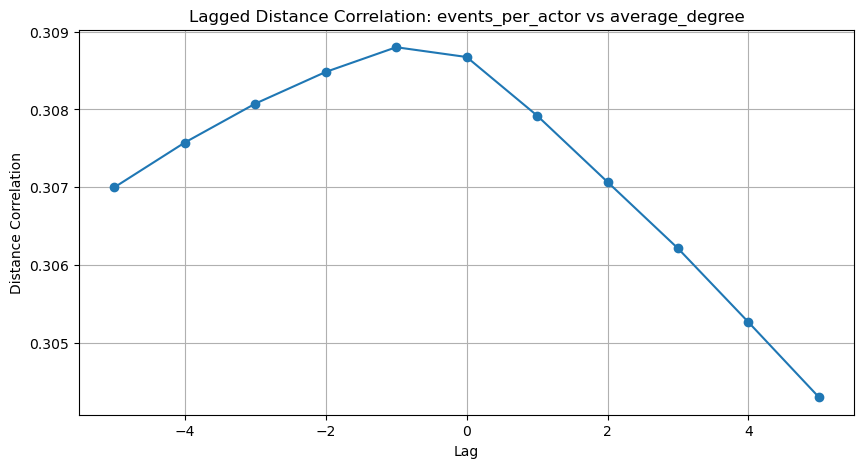

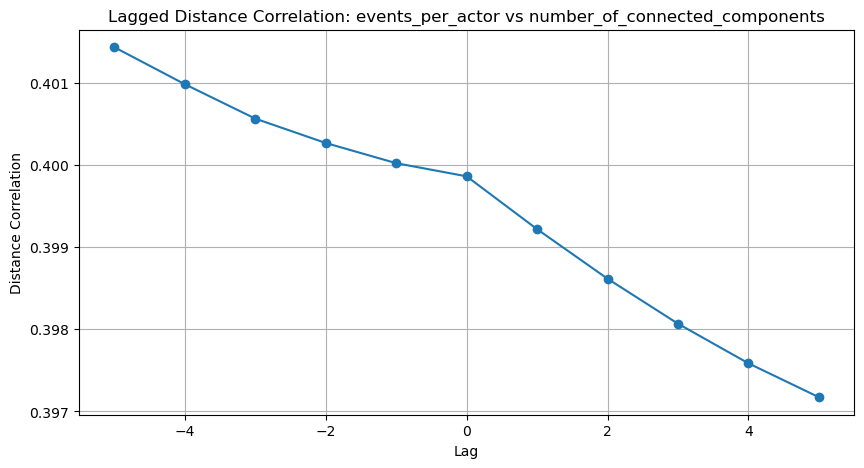

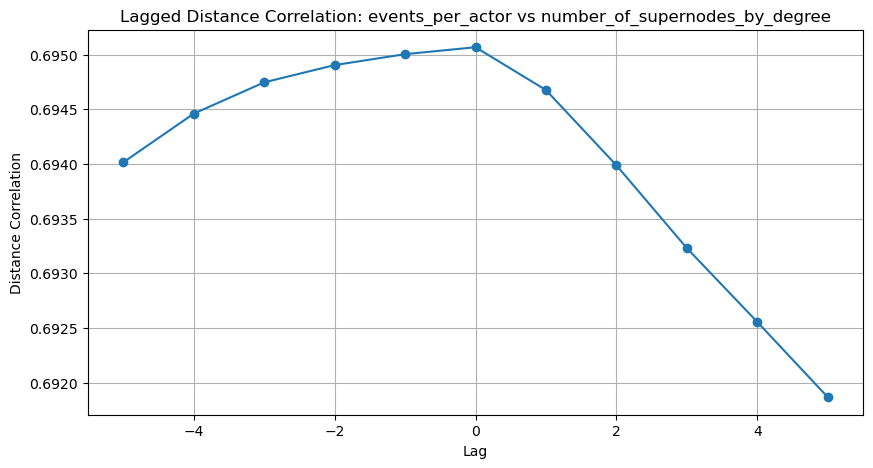

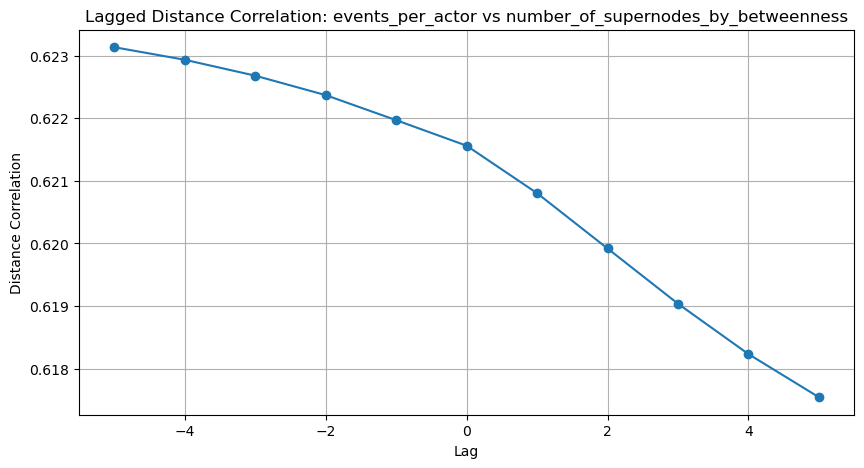

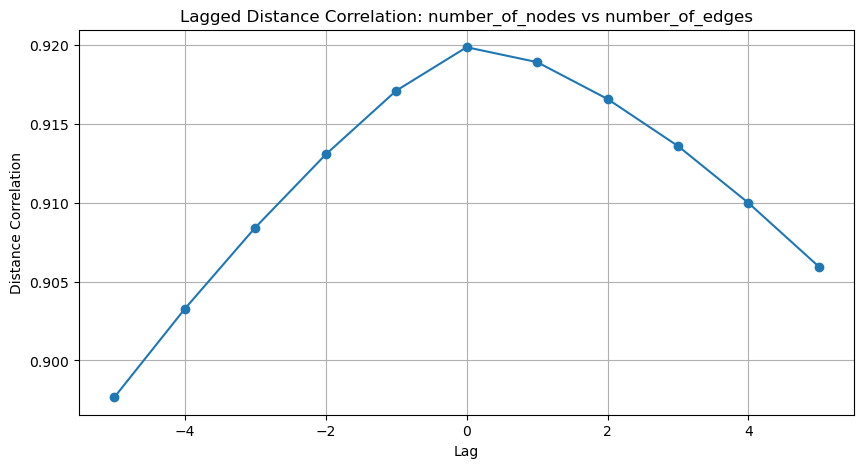

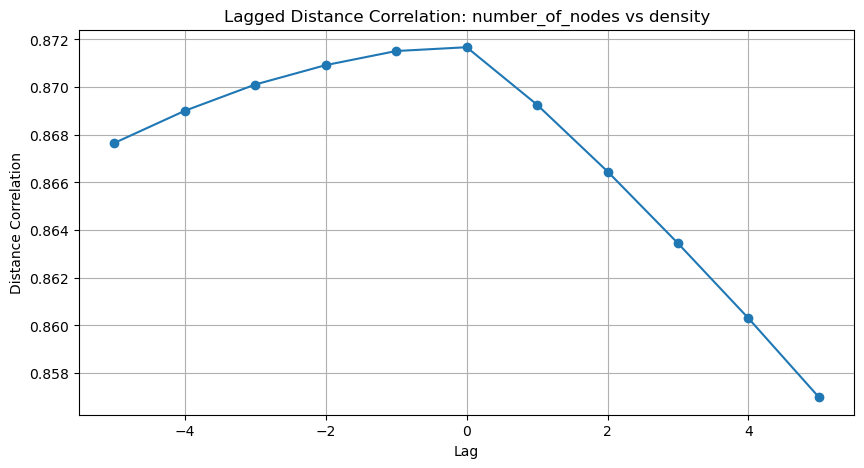

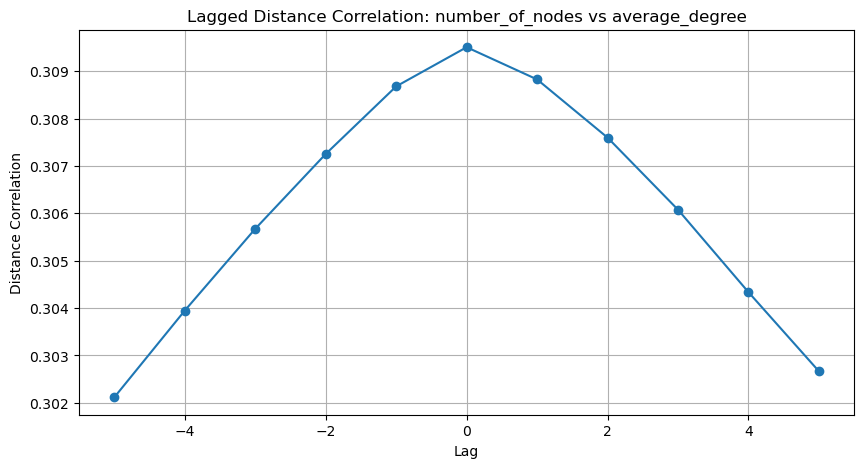

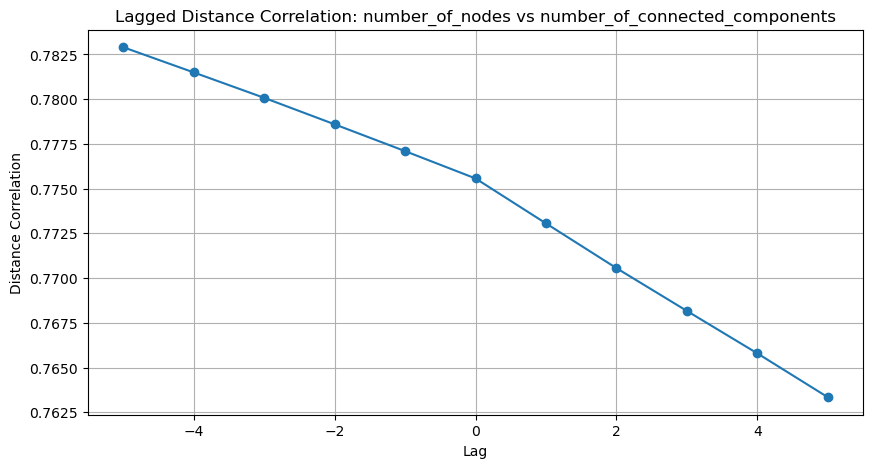

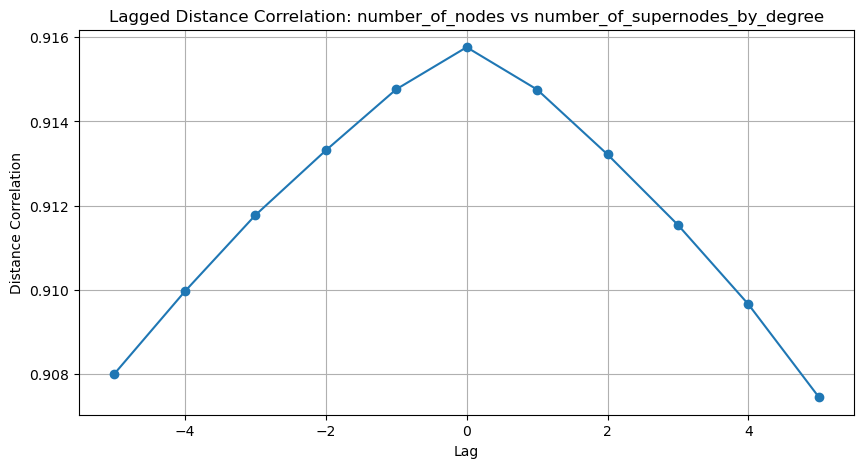

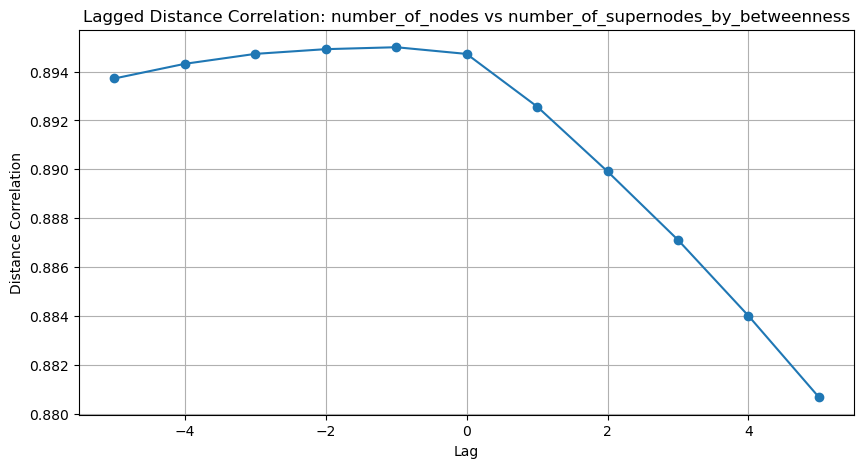

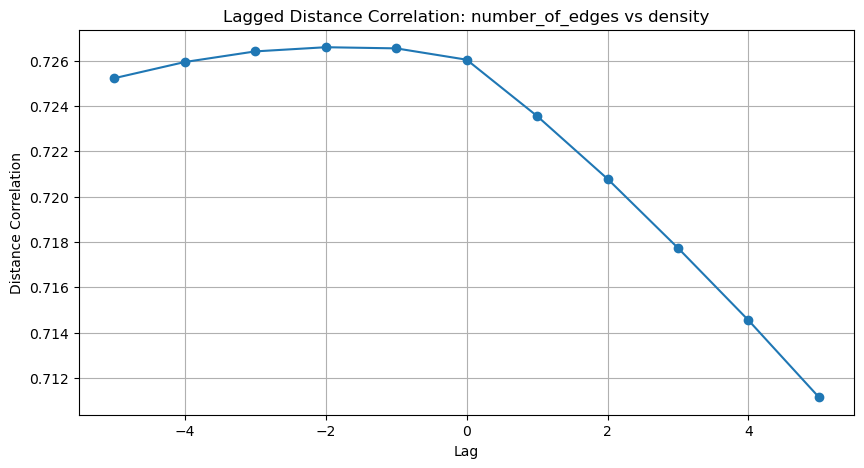

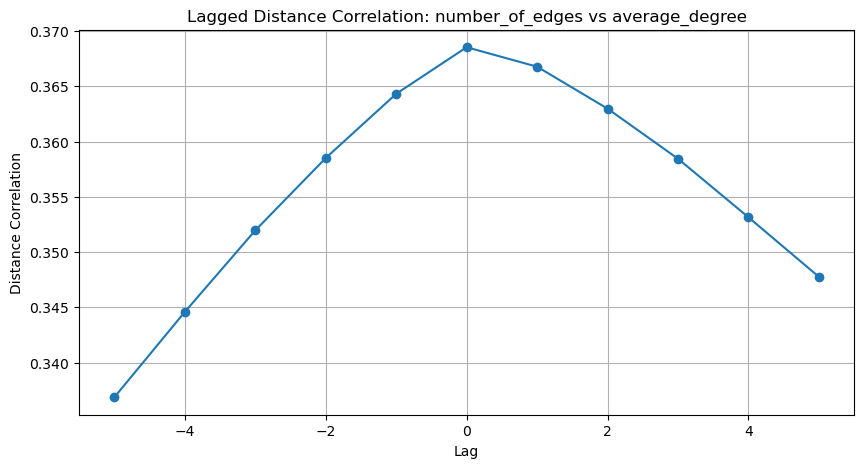

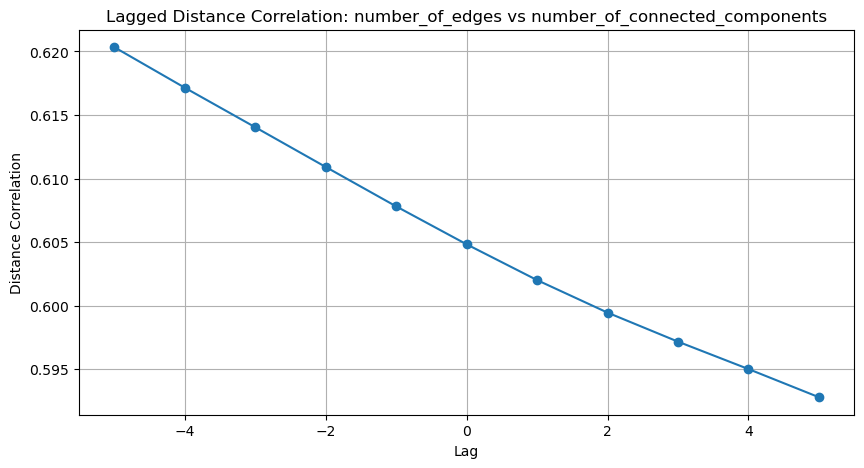

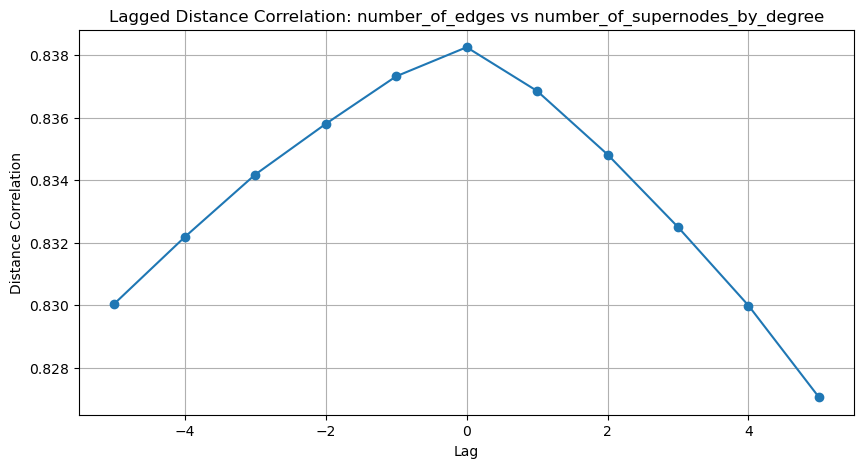

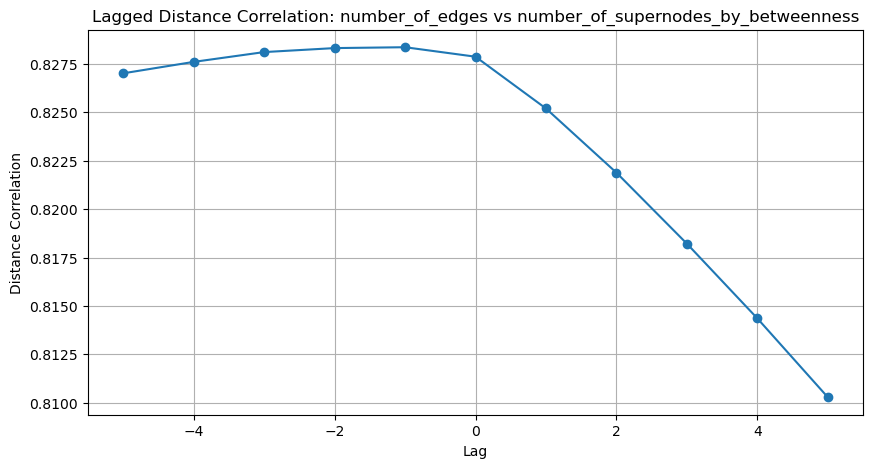

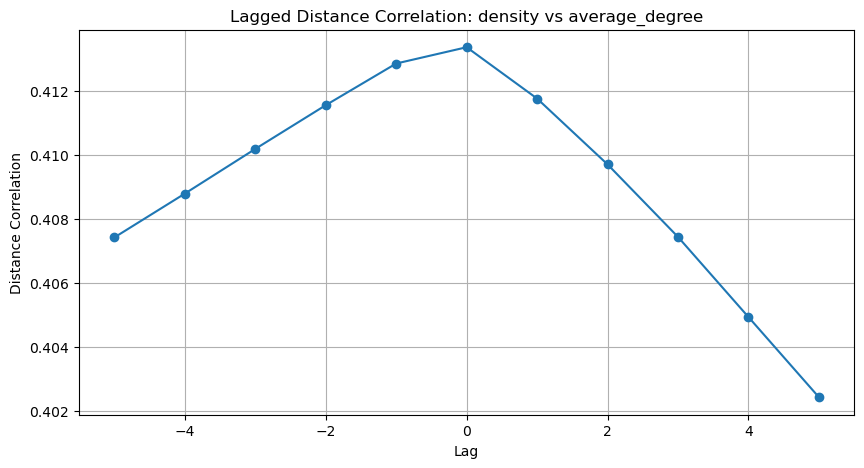

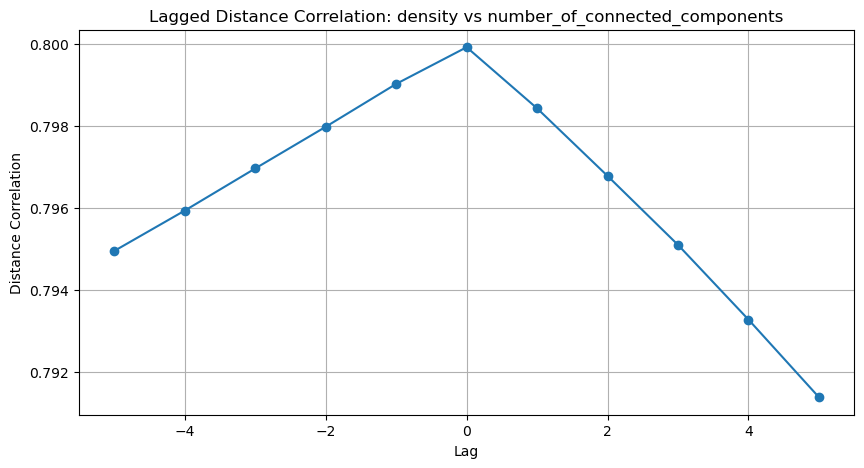

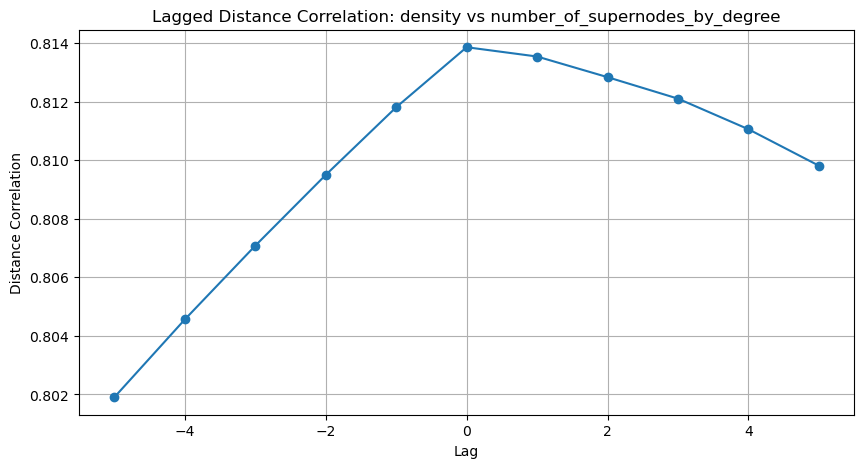

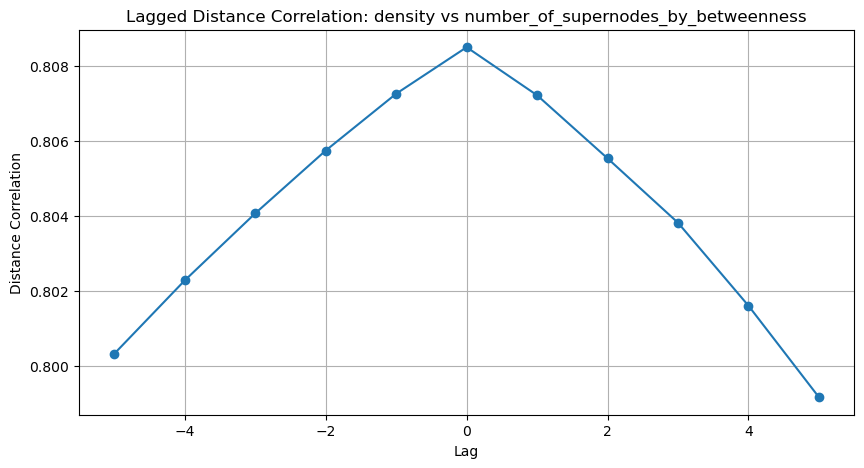

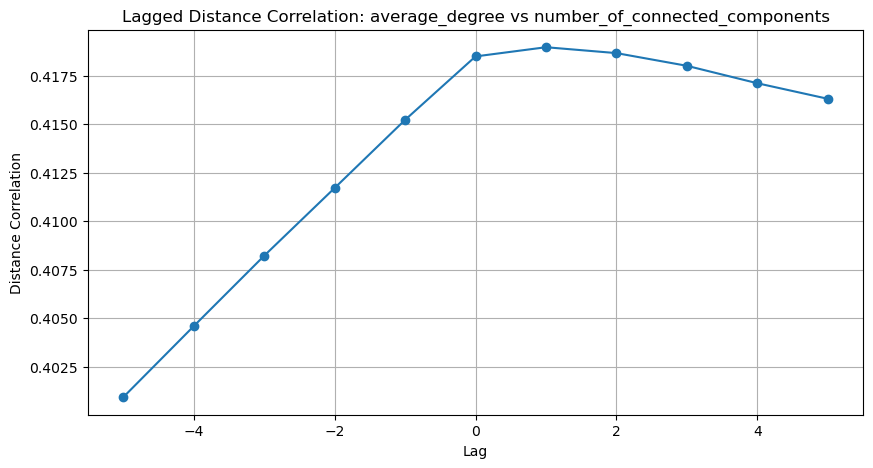

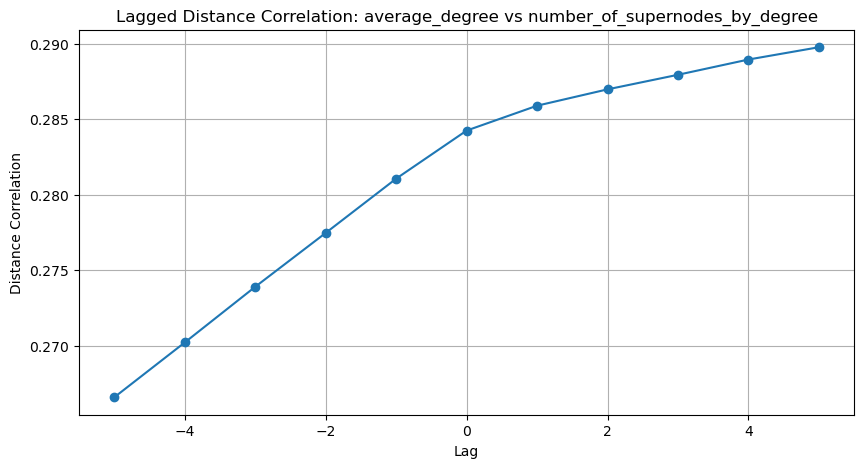

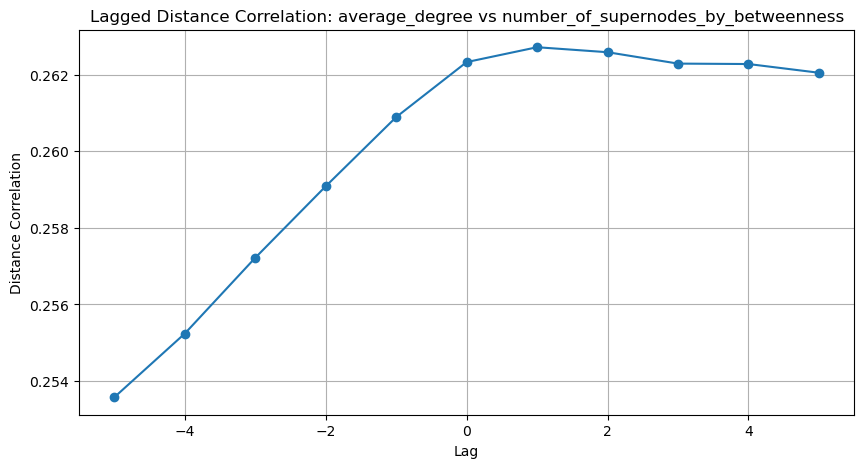

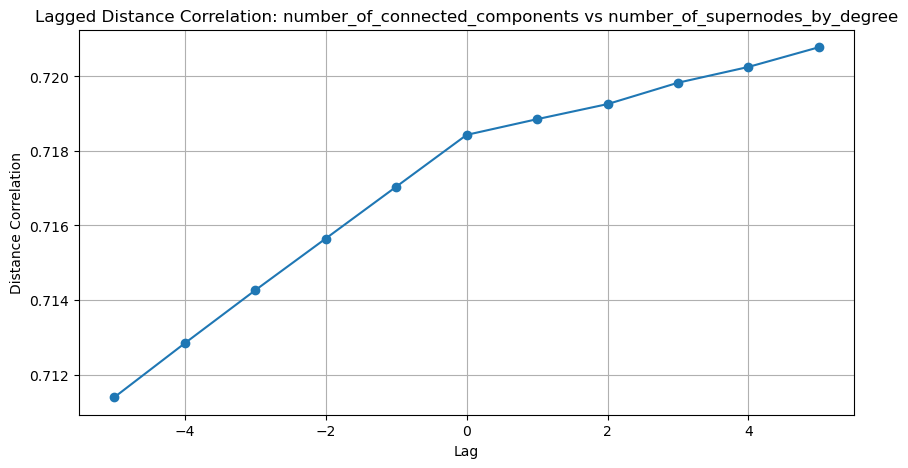

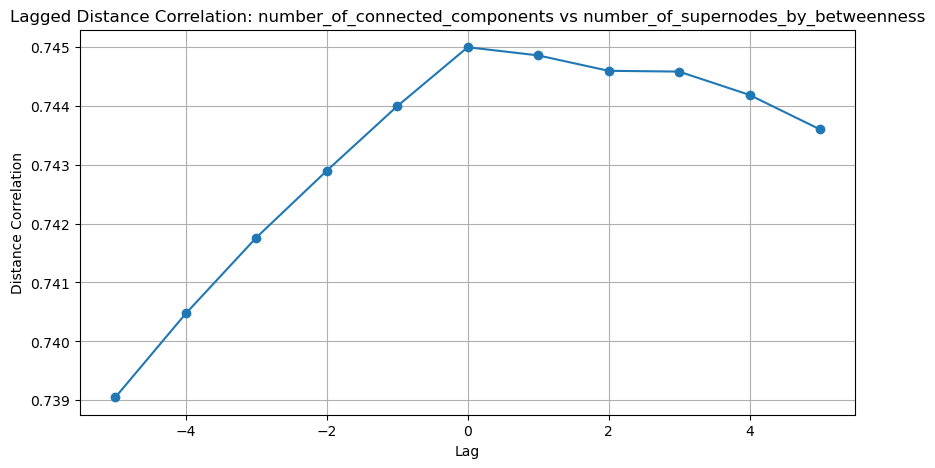

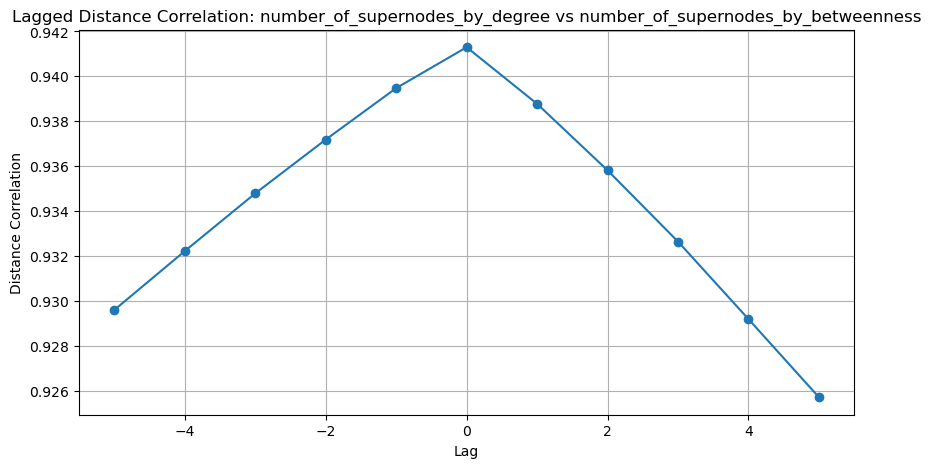

In [26]:
# Run pairwise lagged distance correlation
results = utils.lagged_distance_correlation_all_pairs(stats_and_metrics_df, max_lag=5)

# Plot each pair
for (col_x, col_y), values in results.items():
    lags, dcor_values = zip(*values)
    plt.figure(figsize=(10, 5))
    plt.plot(lags, dcor_values, marker='o')
    plt.title(f"Lagged Distance Correlation: {col_x} vs {col_y}")
    plt.xlabel("Lag")
    plt.ylabel("Distance Correlation")
    plt.grid(True)
    plt.show()


In [ ]:
dcor_df = utils.distance_correlation_dataframe(stats_and_metrics_df)
dcor_matrix = dcor_df.to_pandas().pivot(index="col_x", columns="col_y", values="dcor")

plt.figure(figsize=(8, 6))
    sns.heatmap(dcor_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    plt.title("Distance Correlation Matrix")
    plt.tight_layout()
    plt.show()